## Genetic Algorithms
Naively mimicking nature evolution. Generally used to generate high-quality solutions to optimization and search problems.
Here I'll try to implement three variants of the method, basic fitness based probability, fitness ranked individuals probability and fitnes + diversity ranked individuals.

<p align="center">
    <img src=".\images\ga_pipeline.png" alt="ga" width="400"/>
</p>

### Function Maximization Example

In [27]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cbook, colormaps
from matplotlib.colors import LightSource

In [80]:
import matplotlib
matplotlib.pyplot.close("all")

In [53]:
ls = LightSource(270, 45)

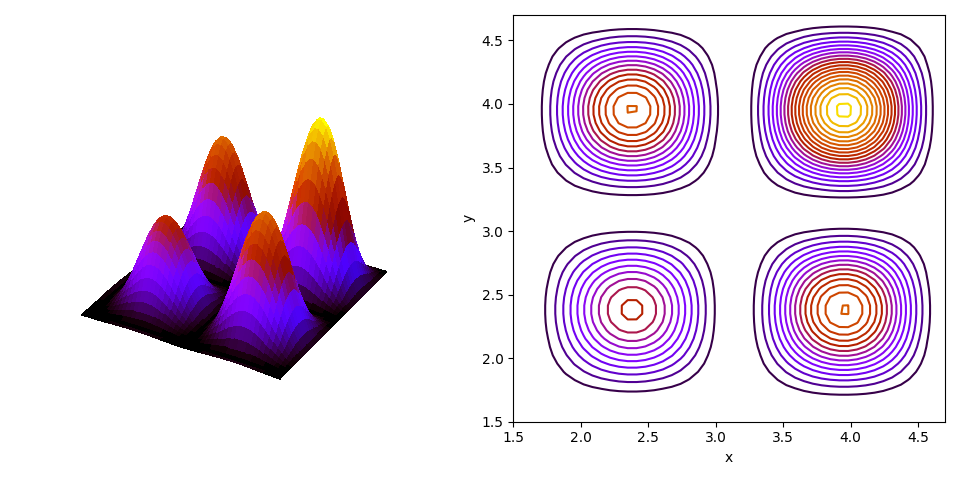

In [92]:
n = 50
x = np.linspace(1.5, 4.7, n)
y = x.copy()
x, y = np.meshgrid(x, y)

z = np.sin(2*x)**2 * np.sin(2*y)**2 * np.exp((x+y)/5)

fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
rgb = ls.shade(z, cmap=colormaps["gnuplot"], vert_exag=0.1, blend_mode='soft')

surf = ax1.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)
ax1.axis("off")

ax2 = fig.add_subplot(1, 2, 2)

ax2.contour(x, y, z, levels=20, cmap=colormaps["gnuplot"])
ax2.set_xlabel("x")
ax2.set_ylabel("y")

plt.tight_layout()
plt.show()

* **Pseudocode**:
1. Initial population: set of $(x, y)$ values such that $x \in [x_{\text{min}}, x_{\text{max}}]$ (idem for $y$)
1. Fitness: $f(x, y)$
1. Selection: Select $k$ (hyperparamenters) that will be eligible for crossover as parents
1. Crossover: Out of the $k$ individuals they are recombined in pairs and, using another hyperparameter $C_p$, they will be crossover or simple pass a copy of the parents as children.
1. Mutation: Small modification of a given individual (bits chunks, step size, ...) also controled by a probability $M_p$.
1. Terminate or loop back

In [160]:
class MaximizeFunction:
    def __init__(self, x_range, y_range, n_pop=1, n_iter=100):
        self.n_pop = n_pop
        self.n_iter = n_iter
        self.population = None

        assert x_range[0] < x_range[1], "Check x range"
        assert y_range[0] < y_range[1], "Check y range"
        self.x_range = x_range
        self.y_range = y_range

        self.init_population()
    
    def init_population(self):
        self.population = np.empty((self.n_pop, 2))
        self.population[:, 0] = np.random.uniform(*self.x_range, size=self.n_pop)
        self.population[:, 1] = np.random.uniform(*self.y_range, size=self.n_pop)
    
    def fitness(self, x, y):
        return np.sin(2*x)**2 * np.sin(2*y)**2 * np.exp((x+y)/5)
    
    def score(self):
        return np.array([self.fitness(*p) for p in self.population])

    def selection(self):
        """Fitness proportionate selection."""
        scores = self.score()
        cumulative_probs = np.cumsum(scores / scores.sum())
        mask = np.random.rand() < cumulative_probs
        
        return self.population[np.argwhere(mask).flatten()[0]]


    def select_parents(self):
        return np.array([self.selection() for _ in range(self.n_pop)])
    
    def crossover(self, parent_a, parent_b, c_prob=0.8):
        new_parent_a = parent_a.copy()
        new_parent_b = parent_b.copy()

        if np.random.rand() < c_prob:
            new_parent_a[1] = parent_b[1]
            new_parent_b[0] = parent_a[0]
            
        return new_parent_a, new_parent_b

    def mutate(self, individual, step=.1, m_prob=0.05):
        """TODO: check if they go out the grid"""
        x = individual[0] + step * np.random.choice([1, 0, -1])
        y = individual[1] + step * np.random.choice([1, 0, -1])
        return np.array([x, y])


    def new_generation(self):
        parents = self.select_parents()
        new_population = []

        for i in range(0, self.n_pop, 2):
            # crossover
            p1, p2 = self.crossover(parents[i], parents[i+1])
            # mutation
            new_population.append(self.mutate(p1))
            new_population.append(self.mutate(p2))
        return np.array(new_population)


            

a = MaximizeFunction([2, 3], [1, 2], n_pop=10)
a.population



array([[2.17741127, 1.69492355],
       [2.98894481, 1.80440839],
       [2.53644697, 1.93710684],
       [2.49584044, 1.83681527],
       [2.98838063, 1.17086768],
       [2.46473257, 1.50575398],
       [2.56952281, 1.01568847],
       [2.28156323, 1.61222326],
       [2.20875899, 1.58137497],
       [2.84265255, 1.31575884]])

In [165]:
np.random.choice([1, -1])

1

In [148]:
mask = np.random.rand() < np.cumsum(a.selection())

In [156]:
np.argwhere(mask).flatten()[0]

array([4, 5, 6, 7, 8, 9], dtype=int64)

In [132]:
for i in range(0, 10, 2):
    print(i)

0
2
4
6
8


### Real map example

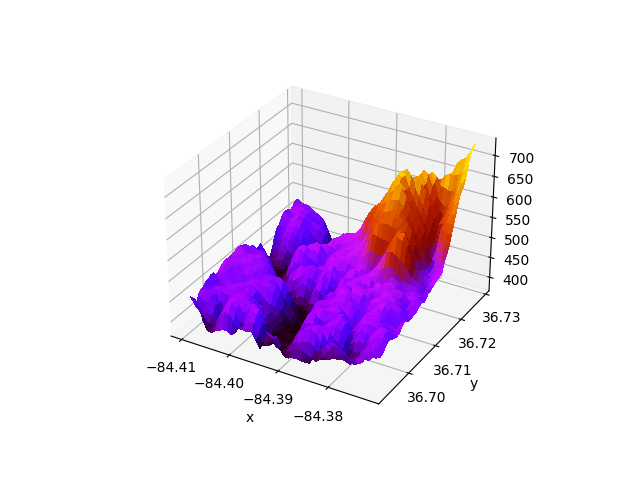

In [40]:
# Load and format data
dem = cbook.get_sample_data('jacksboro_fault_dem.npz', np_load=True)
z = dem['elevation']
nrows, ncols = z.shape
x = np.linspace(dem['xmin'], dem['xmax'], ncols)
y = np.linspace(dem['ymin'], dem['ymax'], nrows)
x, y = np.meshgrid(x, y)

region = np.s_[5:50, 5:50]
x, y, z = x[region], y[region], z[region]

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ls = LightSource(270, 45)

rgb = ls.shade(z, cmap=colormaps["gnuplot"], vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.show()

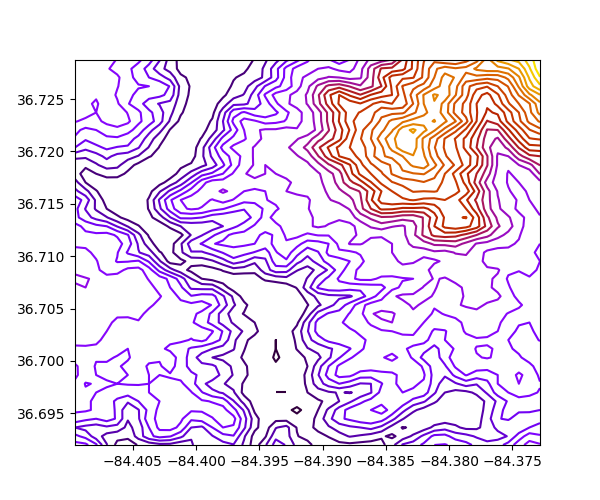

In [26]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.contour(x, y, z, levels=25, cmap=colormaps["gnuplot"])
plt.show()